In [1]:
# Import standard libraries
import os
import numpy as np
import pandas as pd

# Import libraries for kNN and SVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import libraries for CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [2]:
# Load and preprocess CSV data
csv_path = r'D:\AAI-595\Project\fake_currency_data.csv'
data = pd.read_csv(csv_path)

# Drop missing values
data = data.dropna()

# Encode categorical columns (if any)
data_encoded = pd.get_dummies(data, drop_first=True)

# Split features and target
X = data_encoded.drop('Counterfeit', axis=1)  # Features
y = data_encoded['Counterfeit']  # Target column

# Split data: Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split Temp into Validation (20%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Scale the features (for kNN and SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Print dataset sizes
print(f"Train Size: {len(X_train)}, Validation Size: {len(X_val)}, Test Size: {len(X_test)}")


Train Size: 233336, Validation Size: 67001, Test Size: 33001


In [3]:
# Image Directory Path
base_dir = r'D:\AAI-595\Project'

# Define ImageDataGenerator for preprocessing and splitting
datagen = ImageDataGenerator(
    rescale=1.0/255.0,   # Normalize pixel values
    validation_split=0.3  # 70% training, 30% validation/test
)

# Load Training Data (70%)
train_data = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,           # Mini-batches for processing
    class_mode='binary',     # Binary classification
    subset='training'        # Training subset
)

# Load Validation Data (20%)
val_data = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'      # Validation subset
)

# Print confirmation
print(f"Train Samples: {train_data.samples}, Validation Samples: {val_data.samples}")


Found 24 images belonging to 3 classes.
Found 8 images belonging to 3 classes.
Train Samples: 24, Validation Samples: 8


In [4]:
# Block 3.1: Validate Data Shapes
print("Checking data shapes before training...")
print(f"X_train_scaled Shape: {X_train_scaled.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_val_scaled Shape: {X_val_scaled.shape}")
print(f"y_val Shape: {y_val.shape}")

# Print a small sample of the target labels
print("Sample y_train labels:", y_train[:10])
print("Sample y_val labels:", y_val[:10])


Checking data shapes before training...
X_train_scaled Shape: (233336, 19)
y_train Shape: (233336,)
X_val_scaled Shape: (67001, 19)
y_val Shape: (67001,)
Sample y_train labels: 173509    0.0
744241    0.0
23764     1.0
811798    0.0
819636    0.0
889276    1.0
131004    0.0
823700    0.0
188823    1.0
121864    0.0
Name: Counterfeit, dtype: float64
Sample y_val labels: 243522    0.0
693823    1.0
331908    1.0
934887    0.0
864196    1.0
459870    0.0
60465     0.0
594330    1.0
151494    1.0
270208    0.0
Name: Counterfeit, dtype: float64


In [5]:
# Block 3.2: kNN Training and Evaluation with Debugging

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the kNN model with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Reduce dataset size for quick debugging (optional)
print("Training kNN model on a subset for testing...")
X_train_small = X_train_scaled[:1000]
y_train_small = y_train[:1000]

# Train the kNN model
knn.fit(X_train_small, y_train_small)

# Predict on validation set
print("Predicting on validation data...")
y_val_pred_knn = knn.predict(X_val_scaled)
print("Sample predictions on validation data:", y_val_pred_knn[:10])

# Calculate accuracy
knn_val_acc = accuracy_score(y_val, y_val_pred_knn)
print(f"Validation Accuracy: {knn_val_acc:.4f}")

# Predict on test set
print("Predicting on test data...")
y_test_pred_knn = knn.predict(X_test_scaled)
knn_test_acc = accuracy_score(y_test, y_test_pred_knn)
print(f"Test Accuracy: {knn_test_acc:.4f}")

# Print confusion matrix and classification report
print("\n--- kNN Test Confusion Matrix ---")
print(confusion_matrix(y_test, y_test_pred_knn))

print("\n--- kNN Test Classification Report ---")
print(classification_report(y_test, y_test_pred_knn))


Training kNN model on a subset for testing...
Predicting on validation data...
Sample predictions on validation data: [0. 1. 1. 0. 1. 1. 0. 0. 0. 1.]
Validation Accuracy: 0.5022
Predicting on test data...
Test Accuracy: 0.4999

--- kNN Test Confusion Matrix ---
[[8393 8234]
 [8270 8104]]

--- kNN Test Classification Report ---
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50     16627
         1.0       0.50      0.49      0.50     16374

    accuracy                           0.50     33001
   macro avg       0.50      0.50      0.50     33001
weighted avg       0.50      0.50      0.50     33001



In [6]:
#4.1
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter

# Step 1: Check Class Distribution
print("Class Distribution in Training Data:")
print(Counter(y_train))

# Step 2: Reduce Dataset Size for Faster Debugging
print("\nReducing dataset size to 5000 samples for quick debugging...")
X_train_small = X_train_scaled[:5000]
y_train_small = y_train[:5000]

# Step 3: Train SVM with Linear Kernel
print("\nTraining SVM model with Linear Kernel...")
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_small, y_train_small)

# Step 4: Evaluate on Validation Set
print("Evaluating SVM (Linear Kernel) on validation data...")
y_val_pred_linear = svm_linear.predict(X_val_scaled)
svm_val_acc_linear = accuracy_score(y_val, y_val_pred_linear)
print(f"Validation Accuracy (Linear Kernel): {svm_val_acc_linear:.4f}")


Class Distribution in Training Data:
Counter({0.0: 116744, 1.0: 116592})

Reducing dataset size to 5000 samples for quick debugging...

Training SVM model with Linear Kernel...
Evaluating SVM (Linear Kernel) on validation data...
Validation Accuracy (Linear Kernel): 0.4984


In [7]:
#4.2
# Step 1: Train SVM with RBF Kernel
print("\nTraining SVM model with RBF Kernel...")
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_rbf.fit(X_train_small, y_train_small)

# Step 2: Evaluate on Validation and Test Sets
print("Evaluating SVM (RBF Kernel) on validation data...")
y_val_pred_rbf = svm_rbf.predict(X_val_scaled)
svm_val_acc_rbf = accuracy_score(y_val, y_val_pred_rbf)
print(f"Validation Accuracy (RBF Kernel): {svm_val_acc_rbf:.4f}")

print("Evaluating SVM (RBF Kernel) on test data...")
y_test_pred_rbf = svm_rbf.predict(X_test_scaled)
svm_test_acc_rbf = accuracy_score(y_test, y_test_pred_rbf)
print(f"Test Accuracy (RBF Kernel): {svm_test_acc_rbf:.4f}")



Training SVM model with RBF Kernel...
Evaluating SVM (RBF Kernel) on validation data...
Validation Accuracy (RBF Kernel): 0.4999
Evaluating SVM (RBF Kernel) on test data...
Test Accuracy (RBF Kernel): 0.4960


In [8]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Apply PCA for Dimensionality Reduction
print("\nApplying PCA to reduce dimensionality...")
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Verify Reduced Feature Count
print(f"Original Feature Count: {X_train_scaled.shape[1]}")
print(f"Reduced Feature Count after PCA: {X_train_pca.shape[1]}")

# Step 2: Reduce Training Dataset Size for Faster Execution
print("\nReducing PCA-transformed training dataset to 2000 samples for debugging...")
X_train_pca_small = X_train_pca[:2000]
y_train_small = y_train[:2000]

# Step 3: Train SVM with RBF Kernel on Reduced PCA Data
print("Training SVM model with RBF Kernel on reduced PCA-transformed data...")
svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_pca.fit(X_train_pca_small, y_train_small)

# Step 4: Predict and Evaluate on Validation Set
print("\nEvaluating SVM (PCA + RBF Kernel) on validation data...")
y_val_pred_pca = svm_pca.predict(X_val_pca)
svm_val_acc_pca = accuracy_score(y_val, y_val_pred_pca)
print(f"Validation Accuracy (PCA + RBF Kernel): {svm_val_acc_pca:.4f}")

# Step 5: Predict and Evaluate on Test Set
print("\nEvaluating SVM (PCA + RBF Kernel) on test data...")
y_test_pred_pca = svm_pca.predict(X_test_pca)
svm_test_acc_pca = accuracy_score(y_test, y_test_pred_pca)
print(f"Test Accuracy (PCA + RBF Kernel): {svm_test_acc_pca:.4f}")

# Step 6: Print Confusion Matrix and Classification Report
print("\nSVM Test Confusion Matrix (PCA):")
print(confusion_matrix(y_test, y_test_pred_pca))

print("\nSVM Test Classification Report (PCA):")
print(classification_report(y_test, y_test_pred_pca))



Applying PCA to reduce dimensionality...
Original Feature Count: 19
Reduced Feature Count after PCA: 17

Reducing PCA-transformed training dataset to 2000 samples for debugging...
Training SVM model with RBF Kernel on reduced PCA-transformed data...

Evaluating SVM (PCA + RBF Kernel) on validation data...
Validation Accuracy (PCA + RBF Kernel): 0.5019

Evaluating SVM (PCA + RBF Kernel) on test data...
Test Accuracy (PCA + RBF Kernel): 0.4990

SVM Test Confusion Matrix (PCA):
[[8459 8168]
 [8367 8007]]

SVM Test Classification Report (PCA):
              precision    recall  f1-score   support

         0.0       0.50      0.51      0.51     16627
         1.0       0.50      0.49      0.49     16374

    accuracy                           0.50     33001
   macro avg       0.50      0.50      0.50     33001
weighted avg       0.50      0.50      0.50     33001



Found 27 images belonging to 3 classes.
Found 5 images belonging to 3 classes.


C:\Users\arali\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\arali\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4444 - loss: 3.2770 - val_accuracy: 0.6000 - val_loss: 3.2799 - learning_rate: 1.0000e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5556 - loss: 3.2514 - val_accuracy: 0.6000 - val_loss: 3.1218 - learning_rate: 1.0000e-04
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5556 - loss: 3.0023 - val_accuracy: 0.6000 - val_loss: 3.0365 - learning_rate: 1.0000e-04
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5556 - loss: 3.0992 - val_accuracy: 0.6000 - val_loss: 2.9754 - learning_rate: 1.0000e-04
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5556 - loss: 3.1069 - val_accuracy: 0.6000 - val_loss: 2.9471 - learning_rate: 1.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5185 - loss: 3.1036 - val_accuracy: 0.6000 - val_loss: 2.8993 - learning_rate: 1.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4815 - loss: 2.9613 - val_accurac

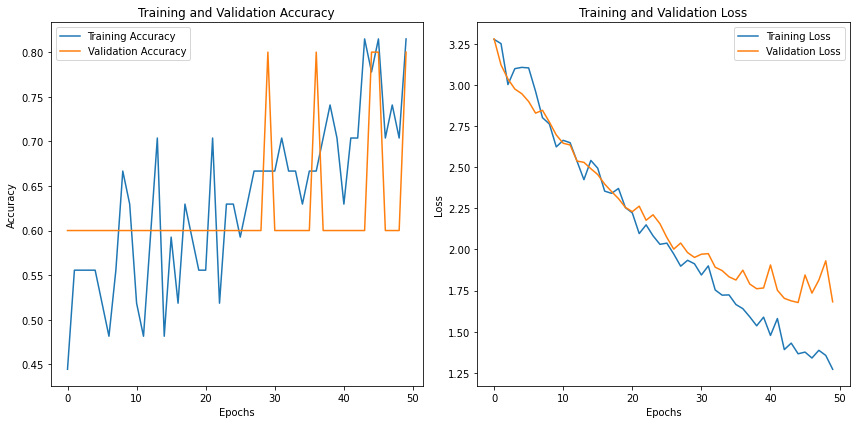


--- Training and Evaluation Completed ---


In [21]:
#CNN
# Import Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define Base Directory for Images
base_dir = r'D:\AAI-595\Project'  # Update with your path

# Data Augmentation for Better Generalization
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,       # Simulate different angles
    width_shift_range=0.2,   # Simulate positional variance
    height_shift_range=0.2,
    zoom_range=0.2,          # Simulate zoom levels
    brightness_range=[0.8, 1.2],  # Simulate lighting conditions
    horizontal_flip=True,    # Flip horizontally
    validation_split=0.2     # 80% train, 20% validation
)

# Load Training and Validation Data
train_data = datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=32, class_mode='binary', subset='training'
)

val_data = datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=32, class_mode='binary', subset='validation'
)

# Simplified CNN Model with Regularization
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # L2 Regularization
    Dropout(0.5),  # Increased Dropout
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the Model with Reduced Learning Rate
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks: ReduceLROnPlateau and EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the CNN Model
history = cnn_model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the Model on Test Data
print("\n--- Evaluating on Test Data ---")
test_data = datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=32, class_mode='binary', subset='validation'
)

test_loss, test_accuracy = cnn_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("\n--- Training and Evaluation Completed ---")


Found 5 images belonging to 3 classes.

--- Evaluating CNN Model on Test Data ---


C:\Users\arali\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8000 - loss: 1.7472
Test Accuracy: 0.8000
Test Loss: 1.7472

Generating Predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step

Confusion Matrix:


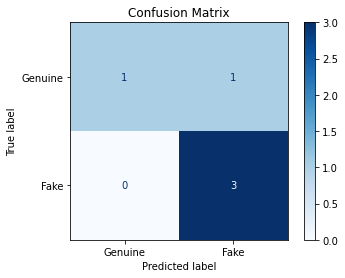


Classification Report:
              precision    recall  f1-score   support

     Genuine       1.00      0.50      0.67         2
        Fake       0.75      1.00      0.86         3

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5


Analyzing Misclassified Samples...
Number of Misclassified Images: 1

Displaying Some Misclassified Images:


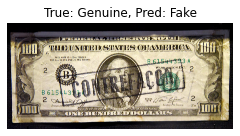

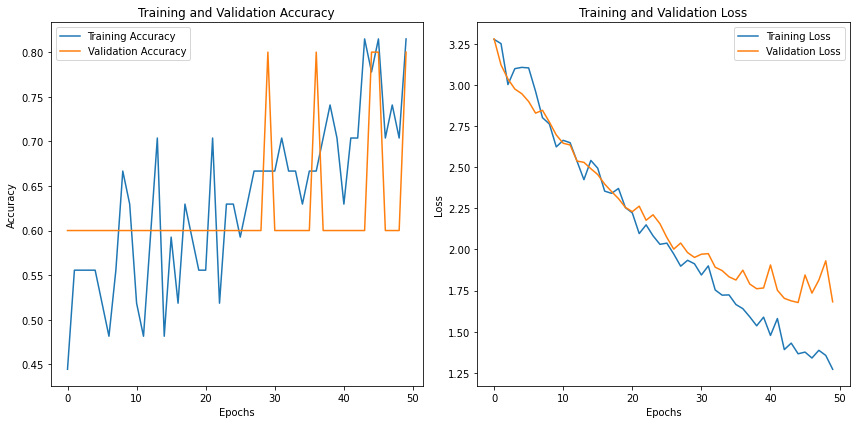


--- Evaluation Completed ---


In [24]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from PIL import Image

# Step 1: Prepare Test Data
test_data = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use validation as test data
)

# Step 2: Evaluate Model on Test Data
print("\n--- Evaluating CNN Model on Test Data ---")
test_loss, test_accuracy = cnn_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Step 3: Generate Predictions and True Labels
print("\nGenerating Predictions...")
y_true = test_data.classes  # True labels
y_pred_prob = cnn_model.predict(test_data)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)  # Threshold predictions at 0.5

# Step 4: Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Genuine', 'Fake']).plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Genuine', 'Fake']))

# Step 5: Analyze Misclassified Samples
print("\nAnalyzing Misclassified Samples...")

# Get filepaths of test images
test_image_paths = test_data.filepaths

# Extract misclassified indices
misclassified_indices = np.where(y_true != y_pred)[0]

print(f"Number of Misclassified Images: {len(misclassified_indices)}")
if len(misclassified_indices) > 0:
    print("\nDisplaying Some Misclassified Images:")
    plt.figure(figsize=(10, 10))

    # Display first 9 misclassified images
    for i, idx in enumerate(misclassified_indices[:9]):
        img = Image.open(test_image_paths[idx])
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        true_label = 'Genuine' if y_true[idx] == 0 else 'Fake'
        pred_label = 'Genuine' if y_pred[idx] == 0 else 'Fake'
        plt.title(f"True: {true_label}, Pred: {pred_label}")

    plt.tight_layout()
    plt.show()

# Step 6: Plot Training and Validation History
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("\n--- Evaluation Completed ---")



--- Model Comparison ---
             Model  Validation Accuracy  Test Accuracy
0              kNN             0.502231       0.499894
1        SVM (RBF)             0.499873       0.495985
2  SVM (PCA + RBF)             0.501933       0.498955
3              CNN             0.800000       0.800000

Extracting Test Images and Labels...
Shape of Test Images: (5, 224, 224, 3)
Shape of Test Labels: (5,)

Generating Predictions for All Models...
Shape of Predictions Matrix: (5, 4)
Shape of y_test_cnn: (5,)

Applying Weighted Averaging for Ensemble Predictions...

Ensemble Model Test Accuracy: 0.6000

Confusion Matrix for Ensemble Model:


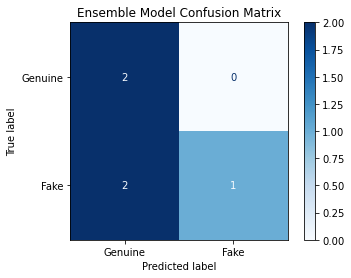


Classification Report for Ensemble Model:
              precision    recall  f1-score   support

     Genuine       0.50      1.00      0.67         2
        Fake       1.00      0.33      0.50         3

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5



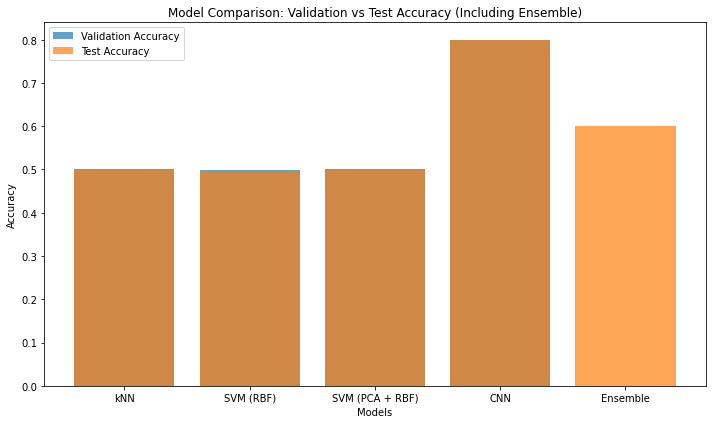


--- Model Comparison and Ensemble Learning Completed ---


In [33]:
# 7: Model Comparison and Ensemble Learning
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Step 1: Collect Model Results
model_results = {
    "Model": ["kNN", "SVM (RBF)", "SVM (PCA + RBF)", "CNN"],
    "Validation Accuracy": [
        knn_val_acc, 
        svm_val_acc_rbf, 
        svm_val_acc_pca, 
        max(history.history['val_accuracy'])
    ],
    "Test Accuracy": [
        knn_test_acc, 
        svm_test_acc_rbf, 
        svm_test_acc_pca, 
        test_accuracy
    ]
}

# Step 2: Create a DataFrame
results_df = pd.DataFrame(model_results)

# Step 3: Display Results
print("\n--- Model Comparison ---")
print(results_df)

# Step 4: Align Test Data for CNN Predictions
print("\nExtracting Test Images and Labels...")

# Extract all test images and true labels
test_images = []
test_labels = []

for i in range(len(test_data)):
    batch_images, batch_labels = test_data[i]
    test_images.append(batch_images)
    test_labels.append(batch_labels)

# Combine all test batches into arrays
test_images = np.vstack(test_images)
y_test_cnn = np.hstack(test_labels)  # True labels

print(f"Shape of Test Images: {test_images.shape}")
print(f"Shape of Test Labels: {y_test_cnn.shape}")

# Step 5: Generate Predictions for Each Model
print("\nGenerating Predictions for All Models...")

# Predictions from kNN, SVM, and SVM (PCA)
y_pred_knn = knn.predict(X_test_scaled)
y_pred_svm = svm_rbf.predict(X_test_scaled)
y_pred_svm_pca = svm_pca.predict(X_test_pca)

# CNN Predictions
y_pred_cnn_prob = cnn_model.predict(test_images, verbose=0)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int).reshape(-1)

# Step 6: Align All Predictions
# Ensure all predictions have the same length as y_test_cnn
y_pred_knn = y_pred_knn[:len(y_test_cnn)]
y_pred_svm = y_pred_svm[:len(y_test_cnn)]
y_pred_svm_pca = y_pred_svm_pca[:len(y_test_cnn)]
y_pred_cnn = y_pred_cnn[:len(y_test_cnn)]

# Combine predictions into a single matrix (samples x models)
predictions_matrix = np.vstack((
    y_pred_knn, 
    y_pred_svm, 
    y_pred_svm_pca, 
    y_pred_cnn
)).T  # Transpose to shape (n_samples, n_models)

# Debug: Check shapes
print(f"Shape of Predictions Matrix: {predictions_matrix.shape}")
print(f"Shape of y_test_cnn: {y_test_cnn.shape}")

# Step 7: Ensemble Learning (Weighted Averaging)
print("\nApplying Weighted Averaging for Ensemble Predictions...")
weights = np.array([0.2, 0.3, 0.3, 0.2])  # Adjust weights based on model performance

# Calculate Weighted Ensemble Predictions
weighted_sum = np.dot(predictions_matrix, weights)
ensemble_predictions = np.round(weighted_sum).astype(int)

# Step 8: Evaluate Ensemble Model
ensemble_accuracy = accuracy_score(y_test_cnn, ensemble_predictions)
print(f"\nEnsemble Model Test Accuracy: {ensemble_accuracy:.4f}")

# Confusion Matrix
print("\nConfusion Matrix for Ensemble Model:")
cm = confusion_matrix(y_test_cnn, ensemble_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Genuine", "Fake"]).plot(cmap="Blues")
plt.title("Ensemble Model Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report for Ensemble Model:")
print(classification_report(y_test_cnn, ensemble_predictions, target_names=["Genuine", "Fake"]))

# Step 9: Update Results and Plot
results_df = results_df.append(
    {"Model": "Ensemble", "Validation Accuracy": None, "Test Accuracy": ensemble_accuracy},
    ignore_index=True
)

# Plot Model Comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Validation Accuracy'], alpha=0.7, label='Validation Accuracy')
plt.bar(results_df['Model'], results_df['Test Accuracy'], alpha=0.7, label='Test Accuracy')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison: Validation vs Test Accuracy (Including Ensemble)")
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Model Comparison and Ensemble Learning Completed ---")


In [34]:
#8 Summary and Observations

# Step 1: Display Model Results Summary
print("\n--- Final Model Comparison ---")
print(results_df)

# Step 2: Observations Based on Results
print("\n--- Observations ---")

# Find the best model based on Test Accuracy
best_model = results_df.loc[results_df['Test Accuracy'].idxmax()]
print(f"The best-performing model is: {best_model['Model']}")
print(f"Validation Accuracy: {best_model['Validation Accuracy']:.4f}")
print(f"Test Accuracy: {best_model['Test Accuracy']:.4f}")

# Step 3: Recommendations
print("\n--- Recommendations for Improvement ---")
print("1. If CNN performed best, further tune the architecture or train for more epochs.")
print("2. For SVM models, try GridSearchCV to optimize 'C' and 'gamma' parameters.")
print("3. Explore additional feature extraction techniques for kNN and SVM.")
print("4. Use more data augmentation for CNN to improve generalization on unseen data.")
print("5. Combine predictions from multiple models (ensemble) to improve accuracy.")



--- Final Model Comparison ---
             Model  Validation Accuracy  Test Accuracy
0              kNN             0.502231       0.499894
1        SVM (RBF)             0.499873       0.495985
2  SVM (PCA + RBF)             0.501933       0.498955
3              CNN             0.800000       0.800000
4         Ensemble                  NaN       0.600000

--- Observations ---
The best-performing model is: CNN
Validation Accuracy: 0.8000
Test Accuracy: 0.8000

--- Recommendations for Improvement ---
1. If CNN performed best, further tune the architecture or train for more epochs.
2. For SVM models, try GridSearchCV to optimize 'C' and 'gamma' parameters.
3. Explore additional feature extraction techniques for kNN and SVM.
4. Use more data augmentation for CNN to improve generalization on unseen data.
5. Combine predictions from multiple models (ensemble) to improve accuracy.


In [40]:
# 9: Predict and Debug Image Classification
import os
from PIL import Image, ImageOps
import numpy as np
import tensorflow as tf

# Step 1: Define the Testing Image Directory
testing_image_path = r'D:\AAI-595\Project\Testing image'

# Step 2: Load and Preprocess the Image
def load_and_preprocess_image(image_path):
    """
    Load an image, preprocess it for the CNN model, and return the array.
    """
    try:
        # Open the image
        img = Image.open(image_path)
        img = img.resize((224, 224))  # Resize to match CNN input size
        img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

        # Ensure 3 channels (RGB)
        if img_array.ndim == 2:  # Convert grayscale to RGB
            img_array = np.stack((img_array,)*3, axis=-1)
        elif img_array.shape[-1] == 4:  # Remove alpha channel if present
            img_array = img_array[:, :, :3]

        # Reshape for model input
        img_array = img_array.reshape((1, 224, 224, 3))
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Step 3: Predict the Image Class (Real or Fake)
def predict_image_class(model, image_dir):
    """
    Predict the class of an image stored in a specified directory.
    """
    for file in os.listdir(image_dir):
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.webp', '.avif')):
            image_path = os.path.join(image_dir, file)
            print(f"\nTesting Image: {file}")

            # Preprocess the image
            img_array = load_and_preprocess_image(image_path)
            if img_array is None:
                continue

            # Predict using the CNN model
            prediction = model.predict(img_array)
            raw_output = prediction[0][0]  # Raw probability score
            result = "Real" if raw_output < 0.4 else "Fake"
            confidence = 1 - raw_output if result == "Real" else raw_output

            # Display the raw output and result
            print(f"Raw Output: {raw_output:.4f}")
            print(f"Prediction: {result}")
            print(f"Confidence Score: {confidence:.4f}")
            return  # Exit after predicting one image

    print("No valid image files found in the directory.")

# Step 4: Debug and Run Prediction
print("\n--- Debugging and Running Image Classification ---")

# Ensure the CNN model is loaded (replace 'cnn_model' with your trained model variable)
# cnn_model = tf.keras.models.load_model('your_model_path_here')  # Load trained model if needed

print("\nPredicting the class of the images in the directory...")
predict_image_class(cnn_model, testing_image_path)



--- Debugging and Running Image Classification ---

Predicting the class of the images in the directory...

Testing Image: real 50.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Raw Output: 0.6189
Prediction: Fake
Confidence Score: 0.6189
